在Baseline的单资产DLinear模型上，预测结果取得了稳定的超额准确率，但是也会出现几个问题

1. 由于单资产的数据量有限，导致训练集规模不够大， 容易出现过拟合现象，导致学习不充分

2. 由于模型需要在“预测结果本身是Neutral分类”和“对当前样本做出的预测不够有信心” 两种情况下都要选择放弃预测，从而导致整体预测结果会出现比真实结果更多的Neutral 分类（约90%），模型仅对10%的样本选择做出预测。

为了能提高资金利用效率，防止模型在大多数情况下都在被动等待，我们可以在单资产DLinear Model的基础上，扩展资产的数量，一方面增大数据集，另一方面降低资金利用效率。

在这一阶段，为了防止模型过于复杂，我们暂时还不考虑引入跨资产的截面数据关系，假定这些资产之间是完全无关的，这也符合PatchTST中通道独立的假设，

除了上证50、沪深300、中证500股指期货以外，我们选取了一些成交量好，与宏观经济有强关联的资产种类，例如黄金、原油、焦煤、螺纹钢、热卷、铁矿石、豆粕、棉花

但是由于不同的期货品种共用模型参数，而资产的波动率、行为模式存在差异，导致模型的预测能力下降了。

对此，我们可以有两个解决方法

1. 两阶段训练模式，先训练整体，再根据目标微调参数

2. 增加资产信息维度，将资产信息嵌入到价格数据中，让模型学会根据资产信息改变参数

我们先实现第一种思路

In [1]:
import os
os.chdir('d:/future/Index_Future_Prediction')

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from scipy.stats import norm, t

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from utils.random_split import RandomSplit, CallableDataset
from utils.back_test import BackTest
from utils.hybrid_loss import HybridLoss
from utils.hybrid_decoder import HybridDecoder
from utils.prediction_recorder import PredictionRecorder
from utils.train_animator import TrainAnimator
from utils.model_train import ModelTrain
from utils.get_ohlcv import GetOHLCV

In [4]:
import tushare as ts
pro = ts.pro_api('700c1d6015ad030ff20bf310c088243da030e6b79a2a1098d58d2614')

In [5]:
from modules.dlinear import DLinear
class DLinearOutput(nn.Module):
    """DLinear作为信息编码层，编码历史信息，然后交给HybridDecoder进行解码"""
    def __init__(self, seq_len, pred_len, individual, enc_in, kernel_size, init_prob, dropout, **kwargs):
        super(DLinearOutput, self).__init__(**kwargs)
        self.device = 'cuda:0'

        self.process = nn.Sequential(
            DLinear(seq_len = seq_len, pred_len =  pred_len, individual = individual, enc_in = enc_in, kernel_size = kernel_size),
            nn.Sequential(nn.Flatten(start_dim = 1), nn.Dropout(dropout))
            )


        self.output = HybridDecoder(pred_len * enc_in, init_prob = init_prob)

    def forward(self, x):
        x = self.process(x)
        return self.output(x)

In [6]:
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'FU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX']

In [7]:
feature = ['open','high','low','close','amount']
label = ['label_return','down_prob','middle_prob','up_prob']

In [8]:
def get_random_split(train_ratio, validation_ratio, test_ratio):
    source = GetOHLCV()
    sample_date = source.get_data('M.DCE', 5, 0.3)
    date_column = sample_date['trade_date'].copy()
    total_size = len(date_column)
    train_size = int(train_ratio * total_size)
    validation_size = int(validation_ratio * total_size)
    test_size = int(test_ratio * total_size)
    random_split = np.random.randint(train_size, total_size - validation_size - test_size)
    validation_start = date_column.iloc[random_split]
    test_start = date_column.iloc[random_split+validation_size]
    test_end = date_column.iloc[random_split+validation_size+test_size]
    return validation_start, test_start, test_end

In [9]:
def get_data_set(assets_list, validation_start, test_start, test_end, seq_len, pred_len, threshold_ratio, std_type):

    source = GetOHLCV()

    train_set = None
    validation_set = None
    test_set = None
    feature_column = ['log_open','log_high','log_low','log_close','log_amount',]
    label_column = ['label_return','down_prob','middle_prob','up_prob']
    
    for code in assets_list:

        data = source.get_data(code, pred_len, threshold_ratio, std_type = std_type)

        train_data = data[data['trade_date'] < validation_start].copy()
        validation_data = data[(data['trade_date'] >= validation_start) & (data['trade_date'] < test_start)].copy()
        test_data = data[(data['trade_date'] >= test_start) & (data['trade_date'] < test_end)].copy()
    
        train_feature = torch.tensor(train_data[feature_column].values, dtype = torch.float32, device = 'cuda:0')
        train_feature = train_feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(1,2)

        validation_feature = torch.tensor(validation_data[feature_column].values, dtype = torch.float32, device = 'cuda:0')
        validation_feature = validation_feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(1,2)

        test_feature = torch.tensor(test_data[feature_column].values, dtype = torch.float32, device = 'cuda:0')
        test_feature = test_feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(1,2)



        train_label = torch.tensor(train_data[label_column].values, dtype = torch.float32, device = 'cuda:0')
        train_label = train_label[seq_len-1:]

        validation_label = torch.tensor(validation_data[label_column].values, dtype = torch.float32, device = 'cuda:0')
        validation_label = validation_label[seq_len-1:]

        test_label = torch.tensor(test_data[label_column].values, dtype = torch.float32, device = 'cuda:0')
        test_label = test_label[seq_len-1:]



        if train_set == None:
            train_set = CallableDataset(train_feature, train_label)
        else:
            train_set = train_set + CallableDataset(train_feature, train_label)

        if validation_set == None:
            validation_set = CallableDataset(validation_feature, validation_label)
        else:
            validation_set = validation_set + CallableDataset(validation_feature, validation_label)
        
        if test_set == None:
            test_set = CallableDataset(test_feature, test_label)
        else:
            test_set = test_set + CallableDataset(test_feature, test_label)

    return train_set, validation_set, test_set

In [10]:
# start_date = '20150101'
# split_date = '20200101'
# end_date = '20250101'

In [11]:
seq_len = 40
pred_len = 5
train_ratio, validation_ratio, test_ratio = 0.5, 0.2, 0.02
threshold_ratio = 0.25

In [12]:
from utils.get_ohlcv import GetOHLCV
source = GetOHLCV()

In [13]:
source.get_data('M.DCE', 5, 0.3)

,ts_code,trade_date,pre_close,pre_settle,open,high,low,close,settle,change1,...,label_pred_low,label_amplitude,label_amplitude_ma,label_std,upper_bond,lower_bond,threshold,down_prob,middle_prob,up_prob
1452,M.DCE,20120111,2983.0,2981.0,2975.0,2982.0,2965.0,2976.0,2973.0,-5.0,...,2870.0,78.0,94.700,2.108374,0.798759,-1.341816,1.070287,0.797851,0.169937,0.032211
1451,M.DCE,20120112,2976.0,2973.0,2942.0,2948.0,2935.0,2947.0,2941.0,-26.0,...,2870.0,59.0,94.656,2.108898,0.798759,-1.341816,1.070287,0.523532,0.335066,0.141402
1450,M.DCE,20120113,2947.0,2941.0,2921.0,2929.0,2910.0,2913.0,2918.0,-28.0,...,2870.0,80.0,94.696,2.110528,0.810723,-1.341816,1.076269,0.137433,0.333860,0.528706
1449,M.DCE,20120116,2913.0,2918.0,2882.0,2886.0,2870.0,2873.0,2878.0,-45.0,...,2883.0,81.0,94.460,2.118528,0.810723,-1.341816,1.076269,0.031987,0.169503,0.798511
1448,M.DCE,20120117,2873.0,2878.0,2890.0,2909.0,2883.0,2909.0,2894.0,31.0,...,2892.0,72.0,94.204,2.103195,0.810723,-1.341816,1.076269,0.143613,0.340128,0.516259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1711,M.DCE,20250915,3079.0,3087.0,3080.0,3083.0,3032.0,3042.0,3051.0,-45.0,...,2983.0,75.0,108.908,2.691513,1.132066,-1.299127,1.215597,0.361743,0.346918,0.291339
1710,M.DCE,20250916,3042.0,3051.0,3046.0,3058.0,3030.0,3041.0,3046.0,-10.0,...,2907.0,144.0,108.936,2.701284,1.132066,-1.335536,1.233801,0.827686,0.140768,0.031545
1709,M.DCE,20250917,3041.0,3046.0,3042.0,3051.0,2998.0,3002.0,3019.0,-44.0,...,2907.0,139.0,108.944,2.704909,1.132066,-1.350728,1.241397,0.669506,0.243014,0.087481
1708,M.DCE,20250918,3002.0,3019.0,3008.0,3016.0,2990.0,2993.0,3001.0,-26.0,...,2907.0,139.0,108.952,2.703824,1.132066,-1.335536,1.233801,0.446848,0.335164,0.217989


In [14]:
# def get_data_set(assets_list):
#     train_set = None
#     validation_set = None
    

#         feature_tensor = torch.tensor(data[feature].values, dtype = torch.float32, device = 'cuda:0')
#         feature_tensor = feature_tensor.unfold(dimension = 0, size = window_size, step = 1).transpose(1,2)

#         label_tensor = torch.tensor(data[label].values, dtype = torch.float32, device = 'cuda:0')
#         label_tensor = label_tensor[window_size-1:]

#         if validation_set == None:
        
#             validation_set = CallableDataset(feature_tensor, label_tensor)
#         else:
#             validation_set = validation_set + CallableDataset(feature_tensor, label_tensor)
            
#     test_set = validation_set

#     return train_set, validation_set, test_set

In [15]:
# def get_data_set(assets_list):
#     train_set = None
#     validation_set = None
#     for code in assets_list:
#         data = pro.fut_daily(ts_code = code, start_date = start_date, end_date = split_date)
#         data['oi_chg'] = 1
#         data.dropna(inplace=True)
#         data.sort_values(by = 'trade_date', inplace = True)
#         data['log_open'] = np.log(data['open'] / data['pre_close']) * 100 #标准化为对数百分比（不含百分号）
#         data['log_high'] = np.log(data['high'] / data['pre_close']) * 100 
#         data['log_low'] = np.log(data['low'] / data['pre_close']) * 100 
#         data['log_close'] = np.log(data['close'] / data['pre_close']) * 100
#         data['log_amount'] = np.log(data['amount'] / data['amount'].shift(1)) * 10

#         data['label_return'] = data['log_close'].rolling(window = pred_len).sum().shift(-pred_len) # 标准化为对数百分比（不含百分号），可以直接相加
#         data['label_std'] = data['amount'].rolling(window = pred_len).mean().shift(-pred_len)/data['amount'].mean() * data['label_return'].std()

#         threshold = (abs(data['label_return'].quantile(0.72)) + abs(data['label_return'].quantile(0.28)))/2
#         amount_mean = data['amount'].mean()
#         return_std = data['label_return'].std()

#         def down_probability(row):
#             return norm.cdf(-threshold, loc = row['label_return'], scale=row['label_std'])

#         def middle_probability(row):
#             return norm.cdf(threshold, loc = row['label_return'], scale=row['label_std']) - norm.cdf(-threshold, loc = row['label_return'], scale=row['label_std'])

#         def up_probability(row):
#             return 1 - norm.cdf(threshold, loc = row['label_return'], scale=row['label_std'])
        
#         data['down_prob'] = data.apply(down_probability, axis = 1)
#         data['middle_prob'] = data.apply(middle_probability, axis = 1)
#         data['up_prob'] = data.apply(up_probability, axis = 1)
        
#         data.dropna(inplace=True)

#         feature_tensor = torch.tensor(data[feature].values, dtype = torch.float32, device = 'cuda:0')
#         feature_tensor = feature_tensor.unfold(dimension = 0, size = window_size, step = 1).transpose(1,2)

#         label_tensor = torch.tensor(data[label].values, dtype = torch.float32, device = 'cuda:0')
#         label_tensor = label_tensor[window_size-1:]

#         if train_set == None:
        
#             train_set = CallableDataset(feature_tensor, label_tensor)
#         else:
#             train_set = train_set + CallableDataset(feature_tensor, label_tensor)

        
        
#         data = pro.fut_daily(ts_code = code, start_date = split_date, end_date = end_date)
#         data['oi_chg'] = 1
#         data.dropna(inplace=True)
#         data.sort_values(by = 'trade_date', inplace = True)
#         data['log_open'] = np.log(data['open'] / data['pre_close']) * 100 
#         data['log_high'] = np.log(data['high'] / data['pre_close']) * 100 
#         data['log_low'] = np.log(data['low'] / data['pre_close']) * 100 
#         data['log_close'] = np.log(data['close'] / data['pre_close']) * 100
#         data['log_amount'] = np.log(data['amount'] / data['amount'].shift(1)) * 10

#         data['label_return'] = data['log_close'].rolling(window = pred_len).sum().shift(-pred_len)
#         data['label_std'] = data['amount'].rolling(window = pred_len).mean().shift(-pred_len) / amount_mean * return_std

#         def down_probability(row):
#             return norm.cdf(-threshold, loc = row['label_return'], scale=row['label_std'])

#         def middle_probability(row):
#             return norm.cdf(threshold, loc = row['label_return'], scale=row['label_std']) - norm.cdf(-threshold, loc = row['label_return'], scale=row['label_std'])

#         def up_probability(row):
#             return 1 - norm.cdf(threshold, loc = row['label_return'], scale=row['label_std'])
        
#         data['down_prob'] = data.apply(down_probability, axis = 1)
#         data['middle_prob'] = data.apply(middle_probability, axis = 1)
#         data['up_prob'] = data.apply(up_probability, axis = 1)

#         threshold_test = (abs(data['label_return'].quantile(0.75)) + abs(data['label_return'].quantile(0.25)))/2

#         print(f'{code}: train threshold: {threshold:.2f}, test threshold: {threshold_test:.2f}')

#         data.dropna(inplace=True)

#         feature_tensor = torch.tensor(data[feature].values, dtype = torch.float32, device = 'cuda:0')
#         feature_tensor = feature_tensor.unfold(dimension = 0, size = window_size, step = 1).transpose(1,2)

#         label_tensor = torch.tensor(data[label].values, dtype = torch.float32, device = 'cuda:0')
#         label_tensor = label_tensor[window_size-1:]

#         if validation_set == None:
        
#             validation_set = CallableDataset(feature_tensor, label_tensor)
#         else:
#             validation_set = validation_set + CallableDataset(feature_tensor, label_tensor)
            
#     test_set = validation_set

#     return train_set, validation_set, test_set

In [16]:
# train_set, validation_set, test_set = get_data_set(assets_list)

In [17]:
recorder = PredictionRecorder()
animator = TrainAnimator(figsize=(12,6))

Animator data has been reset.


实现两阶段的训练，由于设置了学习率调度器，在一阶段结束的时候学习率已经被调度到了一个相当低的水平，就不需要重新设置学习率了

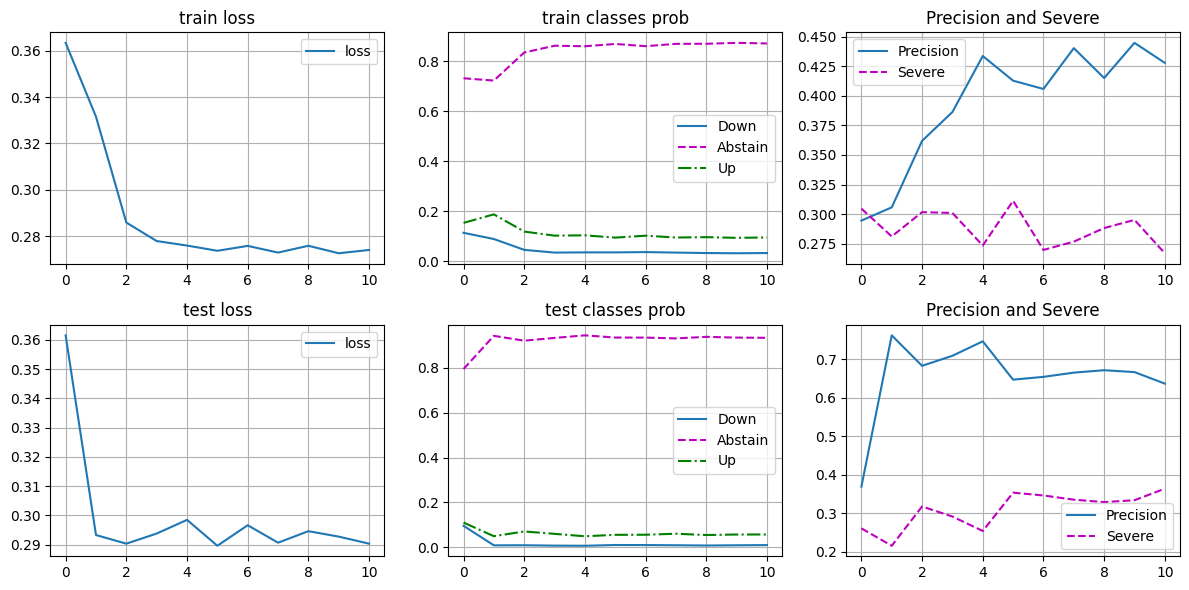

100%|██████████| 100/100 [00:00<00:00, 304.87it/s]


In [ ]:
result = np.zeros(shape = (10, len(assets_list), 4))

for i in range(10):
    validation_start, test_start, test_end = get_random_split(train_ratio, validation_ratio, test_ratio)
    # train_set, validation_set, test_set = get_data_set(assets_list, validation_start, test_start, test_end, seq_len, pred_len, threshold_ratio)

    for j in range(len(assets_list)):
        code = assets_list[j]
        train_set_2, validation_set_2, test_set_2 = get_data_set([code], validation_start, test_start, test_end, seq_len, pred_len, threshold_ratio, std_type='amplitude')

        model = DLinearOutput(seq_len = 40, pred_len = 5, individual = True, enc_in = 5, kernel_size = 21, init_prob = [0.0, 1, 0.0], dropout = 0.5).to('cuda:0')
        
        loss_fn = HybridLoss(alpha = 1e-2, delta = 1)
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 1e-1)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
        train = ModelTrain(model = model,
                        batch_size = 100,
                        train_set = train_set_2,
                        validation_set = validation_set_2,
                        test_set = test_set_2,
                        loss_fn = loss_fn,
                        optimizer = optimizer,
                        scheduler=scheduler,
                        recorder=recorder,
                        graph=animator,
                        )
        
        train.train_set = train_set_2
        train.validation_set = validation_set_2

        prediction, precision = train.epoch_train(epochs = 10, round = 100, early_stop = 10)
        result[i,j,0] = prediction
        result[i,j,1] = precision

        # prediction, precision = train.epoch_train(epochs = 10, round = 100, early_stop = 10)
        # result[i,j,2] = prediction
        # result[i,j,3] = precision

In [ ]:
# all_assets = pd.DataFrame(columns=[
#             'asset',
#             'stage_1_prediction', 'stage_2_prediction',
#             'stage_1_precision', 'stage_2_precision',
#             'stage_1_precision_std','stage_2_precision_std',
#         ])
# for code in assets_list:
#     gap_1 = []
#     prediction_1 = []
#     gap_2 = []
#     prediction_2 = []
#     train_set_fine_tuning, validation_set_fine_tuning, test_set_fine_tuning = get_data_set([code])
#     for i in range(10):

#         animator.reset()
#         model = DLinearOutput(seq_len = 40, pred_len = 5, individual = True, enc_in = 5, kernel_size = 21, init_prob = [0.0, 1, 0.0], dropout = 0.5).to('cuda:0')
#         loss_fn = HybridLoss(alpha = 1e-3, delta = 1)


#         optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 1e-1)
#         scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
#         train = ModelTrain(model = model,
#                         batch_size = 100,
#                     train_set = train_set,
#                     validation_set = validation_set_fine_tuning,
#                     test_set = test_set_fine_tuning,
#                     loss_fn = loss_fn,
#                     optimizer = optimizer,
#                     scheduler=scheduler,
#                     recorder=recorder,
#                     graph=animator,
#                     )
#         prediction, precision = train.epoch_train(epochs = 5, round = 100, early_stop = 10)
#         gap_1.append(precision)
#         prediction_1.append(prediction)

#         train.train_set = train_set_fine_tuning

#         prediction, precision = train.epoch_train(epochs = 5, round = 100, early_stop = 10)

#         gap_2.append(precision)
#         prediction_2.append(prediction)

#     new_records = pd.DataFrame({
#         'asset':[code],
#         'stage_1_prediction': [np.mean(prediction_1)], 
#         'stage_2_prediction': [np.mean(prediction_2)], 

#         'stage_1_precision': [np.mean(gap_1)],  
#         'stage_2_precision': [np.mean(gap_2)], 
        
#         'stage_1_precision_std': [np.std(gap_1)], 
#         'stage_2_precision_std': [np.std(gap_2)], 
#         })
    
#     all_assets = pd.concat([all_assets, new_records], ignore_index=True)

In [ ]:
all_assets = pd.DataFrame({
    'stage_1_prediction': np.mean(result, axis = 0)[:,0],
    'stage_2_prediction': np.mean(result, axis = 0)[:,2],

    'stage_1_precision': np.mean(result, axis = 0)[:,1],
    'stage_2_precision': np.mean(result, axis = 0)[:,3],

    'stage_1_precision_std': np.std(result, axis = 0)[:,1],
    'stage_2_precision_std': np.std(result, axis = 0)[:,3],
})
all_assets.index = pd.Series(assets_list)
for col in all_assets.columns:
    all_assets[col] = all_assets[col].apply(lambda x: f"{x:.1%}")

# 转换为Markdown
markdown_table = all_assets.to_markdown(index=False)
# print(f'hidden_size: {hidden_size}, num_layers: {num_layers}, seq_len: {seq_len}')
print(markdown_table)

| stage_1_prediction   | stage_2_prediction   | stage_1_precision   | stage_2_precision   | stage_1_precision_std   | stage_2_precision_std   |
|:---------------------|:---------------------|:--------------------|:--------------------|:------------------------|:------------------------|
| 10.1%                | 0.0%                 | 1.7%                | 0.0%                | 45.2%                   | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |
| 7.7%                 | 0.0%                 | 13.5%               | 0.0%                | 30.6%                   | 0.0%                    |


可以看到，相比于单一学习的11%，多资产混合学习的7%，两阶段模式取得了显著的正确率提升，过拟合现象也有所缓解。

缺点仍然存在，在二阶段学习时，模型的预测比例仍然会回退到一阶段的10%左右。

<style type="text/css">
</style>
<table id="T_f9e0b">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_f9e0b_level0_col0" class="col_heading level0 col0" >asset</th>
      <th id="T_f9e0b_level0_col1" class="col_heading level0 col1" >stage_1_prediction</th>
      <th id="T_f9e0b_level0_col2" class="col_heading level0 col2" >stage_2_prediction</th>
      <th id="T_f9e0b_level0_col3" class="col_heading level0 col3" >stage_1_precision</th>
      <th id="T_f9e0b_level0_col4" class="col_heading level0 col4" >stage_2_precision</th>
      <th id="T_f9e0b_level0_col5" class="col_heading level0 col5" >stage_1_precision_std</th>
      <th id="T_f9e0b_level0_col6" class="col_heading level0 col6" >stage_2_precision_std</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_f9e0b_level0_row0" class="row_heading level0 row0" >0</th>
      <td id="T_f9e0b_row0_col0" class="data row0 col0" >IH.CFX</td>
      <td id="T_f9e0b_row0_col1" class="data row0 col1" >16.9%</td>
      <td id="T_f9e0b_row0_col2" class="data row0 col2" >10.5%</td>
      <td id="T_f9e0b_row0_col3" class="data row0 col3" >11.9%</td>
      <td id="T_f9e0b_row0_col4" class="data row0 col4" >17.0%</td>
      <td id="T_f9e0b_row0_col5" class="data row0 col5" >10.3%</td>
      <td id="T_f9e0b_row0_col6" class="data row0 col6" >10.4%</td>
    </tr>
    <tr>
      <th id="T_f9e0b_level0_row1" class="row_heading level0 row1" >1</th>
      <td id="T_f9e0b_row1_col0" class="data row1 col0" >IF.CFX</td>
      <td id="T_f9e0b_row1_col1" class="data row1 col1" >16.2%</td>
      <td id="T_f9e0b_row1_col2" class="data row1 col2" >9.1%</td>
      <td id="T_f9e0b_row1_col3" class="data row1 col3" >7.9%</td>
      <td id="T_f9e0b_row1_col4" class="data row1 col4" >16.3%</td>
      <td id="T_f9e0b_row1_col5" class="data row1 col5" >4.8%</td>
      <td id="T_f9e0b_row1_col6" class="data row1 col6" >6.2%</td>
    </tr>
    <tr>
      <th id="T_f9e0b_level0_row2" class="row_heading level0 row2" >2</th>
      <td id="T_f9e0b_row2_col0" class="data row2 col0" >IC.CFX</td>
      <td id="T_f9e0b_row2_col1" class="data row2 col1" >23.8%</td>
      <td id="T_f9e0b_row2_col2" class="data row2 col2" >14.2%</td>
      <td id="T_f9e0b_row2_col3" class="data row2 col3" >7.3%</td>
      <td id="T_f9e0b_row2_col4" class="data row2 col4" >11.0%</td>
      <td id="T_f9e0b_row2_col5" class="data row2 col5" >6.5%</td>
      <td id="T_f9e0b_row2_col6" class="data row2 col6" >6.8%</td>
    </tr>
    <tr>
      <th id="T_f9e0b_level0_row3" class="row_heading level0 row3" >3</th>
      <td id="T_f9e0b_row3_col0" class="data row3 col0" >AU.SHF</td>
      <td id="T_f9e0b_row3_col1" class="data row3 col1" >2.3%</td>
      <td id="T_f9e0b_row3_col2" class="data row3 col2" >13.9%</td>
      <td id="T_f9e0b_row3_col3" class="data row3 col3" >2.3%</td>
      <td id="T_f9e0b_row3_col4" class="data row3 col4" >0.5%</td>
      <td id="T_f9e0b_row3_col5" class="data row3 col5" >19.2%</td>
      <td id="T_f9e0b_row3_col6" class="data row3 col6" >8.5%</td>
    </tr>
    <tr>
      <th id="T_f9e0b_level0_row4" class="row_heading level0 row4" >4</th>
      <td id="T_f9e0b_row4_col0" class="data row4 col0" >FU.SHF</td>
      <td id="T_f9e0b_row4_col1" class="data row4 col1" >80.5%</td>
      <td id="T_f9e0b_row4_col2" class="data row4 col2" >85.1%</td>
      <td id="T_f9e0b_row4_col3" class="data row4 col3" >3.2%</td>
      <td id="T_f9e0b_row4_col4" class="data row4 col4" >-0.6%</td>
      <td id="T_f9e0b_row4_col5" class="data row4 col5" >3.5%</td>
      <td id="T_f9e0b_row4_col6" class="data row4 col6" >1.8%</td>
    </tr>
    <tr>
      <th id="T_f9e0b_level0_row5" class="row_heading level0 row5" >5</th>
      <td id="T_f9e0b_row5_col0" class="data row5 col0" >JM.DCE</td>
      <td id="T_f9e0b_row5_col1" class="data row5 col1" >84.4%</td>
      <td id="T_f9e0b_row5_col2" class="data row5 col2" >83.7%</td>
      <td id="T_f9e0b_row5_col3" class="data row5 col3" >2.3%</td>
      <td id="T_f9e0b_row5_col4" class="data row5 col4" >2.9%</td>
      <td id="T_f9e0b_row5_col5" class="data row5 col5" >2.6%</td>
      <td id="T_f9e0b_row5_col6" class="data row5 col6" >2.6%</td>
    </tr>
    <tr>
      <th id="T_f9e0b_level0_row6" class="row_heading level0 row6" >6</th>
      <td id="T_f9e0b_row6_col0" class="data row6 col0" >RB.SHF</td>
      <td id="T_f9e0b_row6_col1" class="data row6 col1" >41.7%</td>
      <td id="T_f9e0b_row6_col2" class="data row6 col2" >46.1%</td>
      <td id="T_f9e0b_row6_col3" class="data row6 col3" >6.8%</td>
      <td id="T_f9e0b_row6_col4" class="data row6 col4" >5.2%</td>
      <td id="T_f9e0b_row6_col5" class="data row6 col5" >3.3%</td>
      <td id="T_f9e0b_row6_col6" class="data row6 col6" >1.6%</td>
    </tr>
    <tr>
      <th id="T_f9e0b_level0_row7" class="row_heading level0 row7" >7</th>
      <td id="T_f9e0b_row7_col0" class="data row7 col0" >HC.SHF</td>
      <td id="T_f9e0b_row7_col1" class="data row7 col1" >40.3%</td>
      <td id="T_f9e0b_row7_col2" class="data row7 col2" >42.9%</td>
      <td id="T_f9e0b_row7_col3" class="data row7 col3" >2.7%</td>
      <td id="T_f9e0b_row7_col4" class="data row7 col4" >2.5%</td>
      <td id="T_f9e0b_row7_col5" class="data row7 col5" >4.1%</td>
      <td id="T_f9e0b_row7_col6" class="data row7 col6" >3.2%</td>
    </tr>
    <tr>
      <th id="T_f9e0b_level0_row8" class="row_heading level0 row8" >8</th>
      <td id="T_f9e0b_row8_col0" class="data row8 col0" >I.DCE</td>
      <td id="T_f9e0b_row8_col1" class="data row8 col1" >88.7%</td>
      <td id="T_f9e0b_row8_col2" class="data row8 col2" >74.6%</td>
      <td id="T_f9e0b_row8_col3" class="data row8 col3" >3.2%</td>
      <td id="T_f9e0b_row8_col4" class="data row8 col4" >3.7%</td>
      <td id="T_f9e0b_row8_col5" class="data row8 col5" >1.9%</td>
      <td id="T_f9e0b_row8_col6" class="data row8 col6" >1.3%</td>
    </tr>
    <tr>
      <th id="T_f9e0b_level0_row9" class="row_heading level0 row9" >9</th>
      <td id="T_f9e0b_row9_col0" class="data row9 col0" >M.DCE</td>
      <td id="T_f9e0b_row9_col1" class="data row9 col1" >24.0%</td>
      <td id="T_f9e0b_row9_col2" class="data row9 col2" >48.9%</td>
      <td id="T_f9e0b_row9_col3" class="data row9 col3" >6.3%</td>
      <td id="T_f9e0b_row9_col4" class="data row9 col4" >2.8%</td>
      <td id="T_f9e0b_row9_col5" class="data row9 col5" >7.3%</td>
      <td id="T_f9e0b_row9_col6" class="data row9 col6" >5.1%</td>
    </tr>
    <tr>
      <th id="T_f9e0b_level0_row10" class="row_heading level0 row10" >10</th>
      <td id="T_f9e0b_row10_col0" class="data row10 col0" >CF.ZCE</td>
      <td id="T_f9e0b_row10_col1" class="data row10 col1" >23.0%</td>
      <td id="T_f9e0b_row10_col2" class="data row10 col2" >41.5%</td>
      <td id="T_f9e0b_row10_col3" class="data row10 col3" >-1.5%</td>
      <td id="T_f9e0b_row10_col4" class="data row10 col4" >-1.2%</td>
      <td id="T_f9e0b_row10_col5" class="data row10 col5" >7.2%</td>
      <td id="T_f9e0b_row10_col6" class="data row10 col6" >4.5%</td>
    </tr>
  </tbody>
</table>